In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1.Importing Libraries**

In [ ]:
import os 
import pandas as pd
import glob
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
import cv2
from sklearn.metrics import multilabel_confusion_matrix
import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve

# **2. Creating datasets**

In [ ]:
def generate_dataset_from_directory(folder_path, size = 224,batch_size = 32): 

    '''fetch all out test data from directory
    folder path is a list of n directories for n class classification '''

    image_generator = ImageDataGenerator(
        samplewise_center=True, #Set each sample mean to 0.
        samplewise_std_normalization= True, # Divide each input by its standard deviation]
        #rescale=1./255,
        validation_split = 0.3
    )

    #create training and testing datasets
    train_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="grayscale",
        target_size = (size, size),
        batch_size  = batch_size,
                                                     
        shuffle=True,
        seed=123,
        subset="training"
    )

    #create training and testing datasets
    val_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="grayscale",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=True,
        seed=123,
        subset="validation"
    )

#     total_images = train_data.n  
#     steps = total_images//batch_size 
#     xtrain , ytrain = [] , []
#     for i in range(steps):
#         a , b = train_data.next()
#         xtrain.extend(a) 
#         ytrain.extend(b)

#     total_images = val_data.n  
#     steps = total_images//batch_size 
#     xval , yval = [] , []
#     for i in range(steps):
#         a , b = val_data.next()
#         xval.extend(a) 
#         yval.extend(b)

    return train_data, val_data

def get_filepath_from_generator(gen):
    if gen.batch_index <=0:
        raise ValueError('Use iterator to move to batch_index > 0')
    idx_l = (gen.batch_index - 1) * gen.batch_size
    idx_r = idx_l + gen.batch_size if idx_l >= 0 else None
    indices = gen.index_array[idx_l:idx_r]
    filenames = [gen.filenames[i] for i in indices]
    return indices, filenames
    



In [ ]:

folder_path = '../input/covid-radiography-dataset/COVID-19_Radiography_Dataset_Derrell/'
train_data, val_data = generate_dataset_from_directory(
    folder_path, size = 128,batch_size = 32)

Found 14818 images belonging to 4 classes.
Found 6347 images belonging to 4 classes.


# **3.Exploratory Data Analysis**

In [ ]:
class_names = train_data.class_indices
print(class_names)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [ ]:
classes = list(class_names.keys())
print(classes)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [ ]:
images,labels = next(train_data)
indices,image_path = get_filepath_from_generator(train_data)
labels = np.argmax(labels, axis=1)
class_dict = train_data.class_indices
class_dict_inv = dict((v, k) for k, v in class_dict.items())
y_names = [class_dict_inv[key] for key in labels]

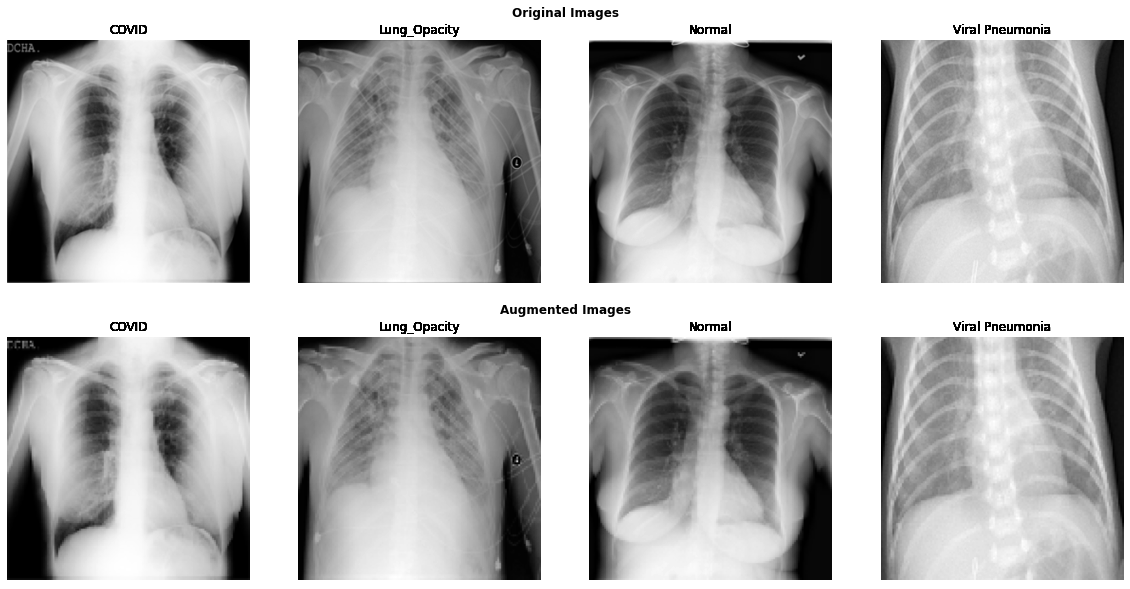

In [ ]:
#Lets visualize the augmented images
fig, big_axes = plt.subplots( figsize=(20, 10) , nrows=2, ncols=1, sharey=True) 
titles = ['Original Images','Augmented Images']
for title, big_ax in zip(titles, big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on = False
    big_ax.axis('off')
for image in images:
    j  = 0
    for i in range(4):
        ax = fig.add_subplot(2, 4, i+1)
        ax1 = fig.add_subplot(2,4,i+1+4)
        for k in range(len(labels)):
            if labels[k] == j:
                og = cv2.imread(folder_path+image_path[k],0)
                ax.imshow(og,cmap = 'gray')
                ax.set_title(classes[i])
                ax.axis("off")
                ax1.imshow(images[k],cmap = 'gray')
                ax1.set_title(classes[i])
                ax1.axis("off")
                break
        j = j+1
plt.show()

In [ ]:
# Investigating single original image
def plot_single_image(raw_image,title):
    plt.imshow(raw_image, cmap='gray')
    plt.colorbar()
    plt.title(title)
    print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
    print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
    print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")
    plt.show()

The dimensions of the image are 299 pixels width and 299 pixels height, one single color channel
The maximum pixel value is 222.0000 and the minimum is 0.0000
The mean value of the pixels is 149.5784 and the standard deviation is 49.4926


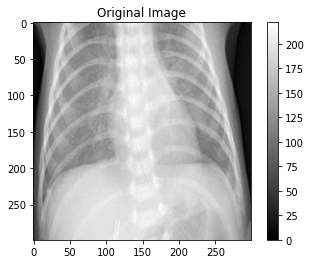

The dimensions of the image are 128 pixels width and 128 pixels height, one single color channel
The maximum pixel value is 1.4452 and the minimum is -3.0251
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


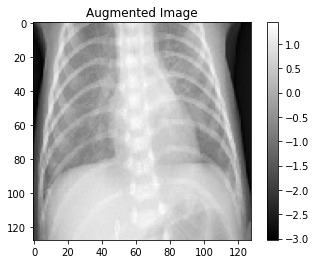

In [ ]:
plt.figure(1)
image = cv2.imread(folder_path+image_path[k],0)
plot_single_image(image,'Original Image')
plt.figure(2)
plot_single_image(images[k],'Augmented Image')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

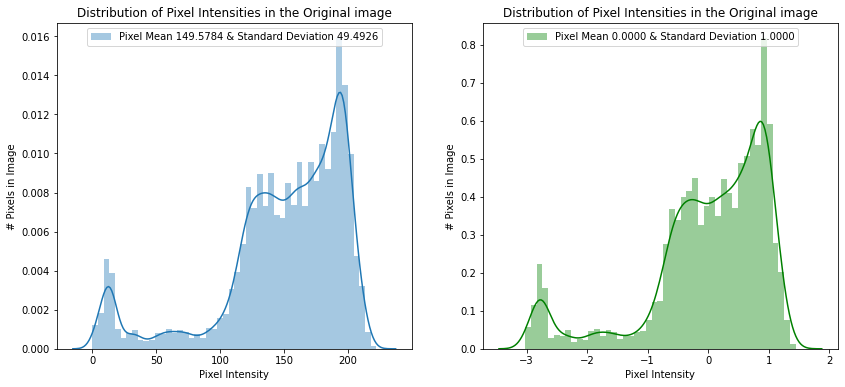

In [ ]:
# Plot a histogram of the distribution of the pixels
sns.despine(left=True)
fig,(ax1,ax2) = plt.subplots(1,2,figsize =(14,6))
sns.distplot(image.ravel(), 
             label=f'Pixel Mean {np.mean(image):.4f} & Standard Deviation {np.std(image):.4f}', kde=True, ax = ax1)
ax1.legend(loc='upper center')
ax1.set_title('Distribution of Pixel Intensities in the Original image')
ax1.set_xlabel('Pixel Intensity')
ax1.set_ylabel('# Pixels in Image')

sns.distplot(images[k].ravel(), 
             label=f'Pixel Mean {np.mean(images[k]):.4f} & Standard Deviation {np.std(images[k]):.4f}', kde=True,color = 'green',ax = ax2)
ax2.legend(loc='upper center')
ax2.set_title('Distribution of Pixel Intensities in the Original image')
ax2.set_xlabel('Pixel Intensity')
ax2.set_ylabel('# Pixels in Image')

plt.show()

In [ ]:
all_items,dirs,files = next(os.walk(folder_path))

In [ ]:
image_in_classes = []
for i in range(len(dirs)):
    no_of_images =len(os.listdir(os.path.join(folder_path,dirs[i])))
    image_in_classes.append(no_of_images)
df_data = {'class': dirs,'counts': image_in_classes}
classes_df = pd.DataFrame(df_data)    
    

In [ ]:
n_classes = len(dirs)

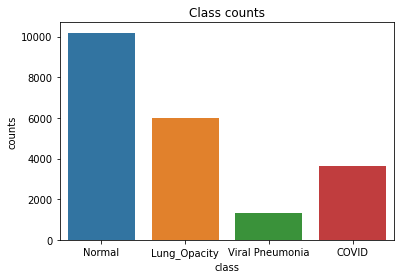

In [ ]:
sns.barplot(x = 'class', y = 'counts',data = classes_df)
plt.title('Class counts')
plt.show()

Comment: As you can see the data is highly imbalanced. We have very less cases of viral pneumonia compared to other classes.

# **4. Predictive Modeling**

### Using Convolutional Neural Networks

In [ ]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].plot(epochRange,history.history['accuracy'],'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()
    
    
    

In [ ]:
def cnn_model(train_data,test_data, epochs,size):
#Building the model using Keras functional API
    print("----Building the model----")
    i = Input(shape=(size,size,1)) #defining input
    x = BatchNormalization()(i)
    x = Conv2D(32,3, activation= 'relu')(i) #adding convolution layers
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(128, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(4, activation= 'softmax')(x)

    model = Model(i,x)
    model.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('cnn_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32,
                  callbacks = [early_stop,mc])
    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(val_data))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 
    

In [ ]:
epochs = 20
r,model,n_epochs = cnn_model(train_data, val_data,epochs,128)

----Building the model----
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None

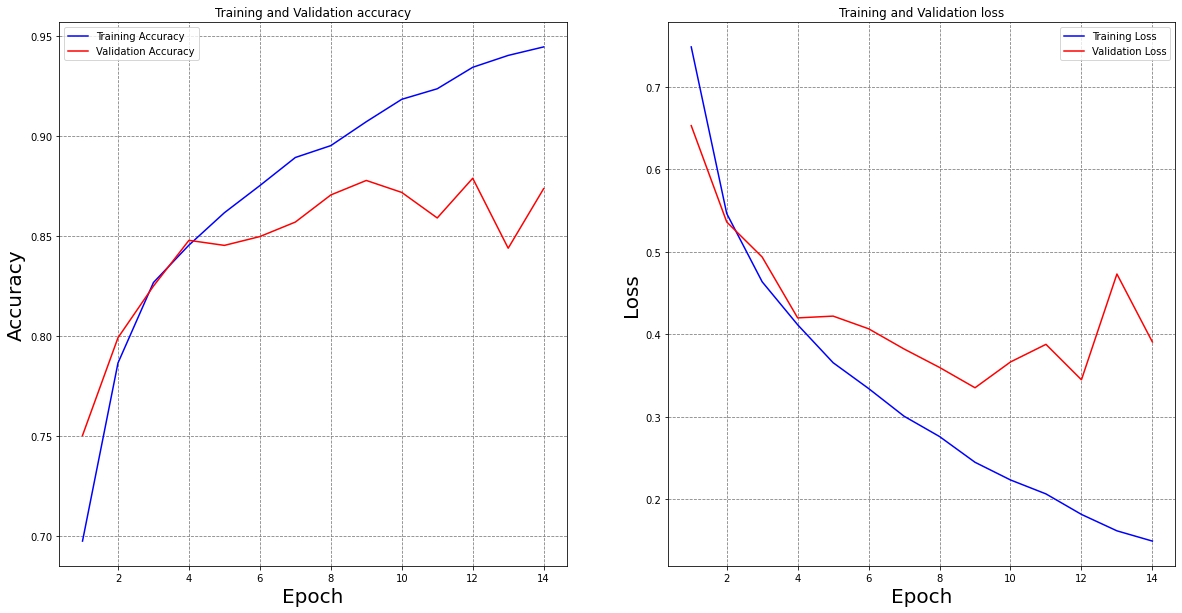

In [ ]:
plotLearningCurve(r,n_epochs)

In [ ]:
# printing model accuracy for train and test data
test_evaluation = model.evaluate(val_data)
print(f"Test Accuracy using CNN: {test_evaluation[1] * 100:.2f}%")

train_evaluation = model.evaluate(train_data)
print(f"Train Accuracy using CNN: {train_evaluation[1] * 100:.2f}%")

199/199 [==============================] - 15s 76ms/step - loss: 0.3352 - accuracy: 0.8776
Test Accuracy using CNN: 87.76%
464/464 [==============================] - 35s 75ms/step - loss: 0.2077 - accuracy: 0.9311
Train Accuracy using CNN: 93.11%


In [ ]:
def extract_from_generator(data):
    data.reset()
    X, y = next(data)
    for i in tqdm.tqdm(range(int(data.n/data.batch_size)-1)): 
        img, label = next(data)
        X = np.append(X, img, axis=0 )
        y = np.append(y, label, axis=0)
    return X,y


In [ ]:
X_train,y_train = extract_from_generator(train_data)
print('X_train:',X_train.shape,'y_train:',y_train.shape)

100%|██████████| 462/462 [01:57<00:00,  3.95it/s]

X_train: (14816, 128, 128, 1) y_train: (14816, 4)


In [ ]:
X_test,y_test = extract_from_generator(val_data)
print('X_test:',X_test.shape,'y_test:',y_test.shape)

100%|██████████| 197/197 [00:29<00:00,  6.68it/s]

X_test: (6336, 128, 128, 1) y_test: (6336, 4)


In [ ]:
y_pred  = np.round(model.predict(X_test))

In [ ]:
y_test_c = np.argmax(y_test,axis = 1) 
y_pred_c = np.argmax(y_pred,axis = 1)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1081
           1       0.88      0.79      0.83      1801
           2       0.88      0.94      0.91      3052
           3       0.88      0.95      0.91       402

   micro avg       0.89      0.87      0.88      6336
   macro avg       0.89      0.86      0.87      6336
weighted avg       0.89      0.87      0.88      6336
 samples avg       0.87      0.87      0.87      6336



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


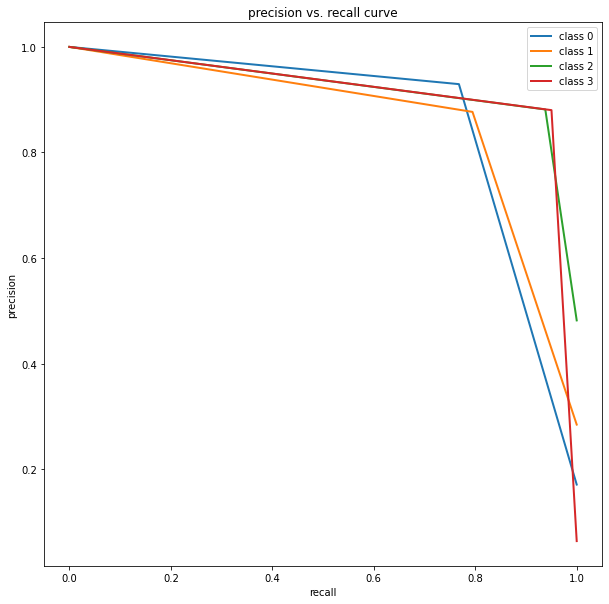

In [ ]:
plt.figure(figsize = (10,10))
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

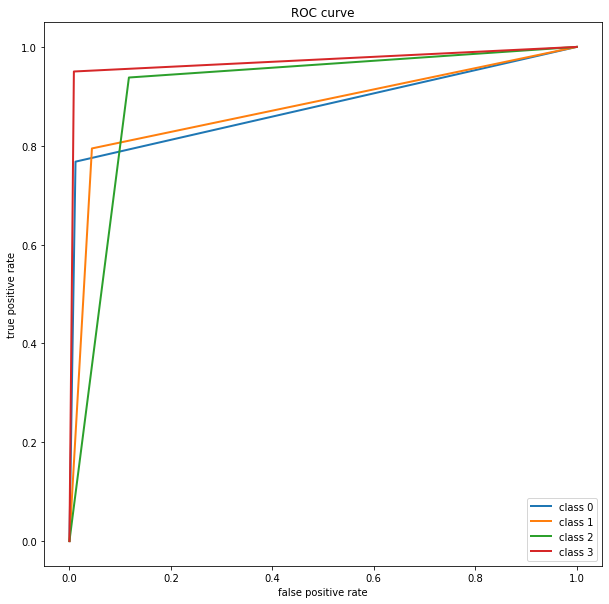

In [ ]:
plt.figure(figsize = (10,10))
fpr = dict()
tpr = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  y_pred[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

### Using Resnet

In [ ]:
def resnet_model(train_data,test_data, epochs,size):
#Building the model using Keras functional API
    print("----Building the model----")
    
    base_model = ResNet50(input_shape= (size,size,1), weights = None, include_top=False)
#     base_model.trainable=False #freezing the layer


    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    out=Dense(4,activation='softmax')(x)

    model=Model(inputs=base_model.input,outputs=out) 
    # model.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('resnet_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32,
                  callbacks = [early_stop,mc])
    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(val_data))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [ ]:
epochs = 20
r,model,n_epochs = resnet_model(train_data, val_data,epochs,128)

----Building the model----
----Training the network----
Epoch 1/20
464/464 - 65s - loss: 0.8195 - accuracy: 0.6623 - val_loss: 1.1468 - val_accuracy: 0.5904

Epoch 00001: val_loss improved from inf to 1.14677, saving model to resnet_model.h5
Epoch 2/20
464/464 - 58s - loss: 0.5592 - accuracy: 0.7819 - val_loss: 0.5384 - val_accuracy: 0.7911

Epoch 00002: val_loss improved from 1.14677 to 0.53835, saving model to resnet_model.h5
Epoch 3/20
464/464 - 58s - loss: 0.4379 - accuracy: 0.8287 - val_loss: 0.4600 - val_accuracy: 0.8251

Epoch 00003: val_loss improved from 0.53835 to 0.45997, saving model to resnet_model.h5
Epoch 4/20
464/464 - 58s - loss: 0.3608 - accuracy: 0.8631 - val_loss: 0.4682 - val_accuracy: 0.8324

Epoch 00004: val_loss did not improve from 0.45997
Epoch 5/20
464/464 - 58s - loss: 0.3101 - accuracy: 0.8818 - val_loss: 0.6204 - val_accuracy: 0.7950

Epoch 00005: val_loss did not improve from 0.45997
Epoch 6/20
464/464 - 59s - loss: 0.2790 - accuracy: 0.8965 - val_loss: 0

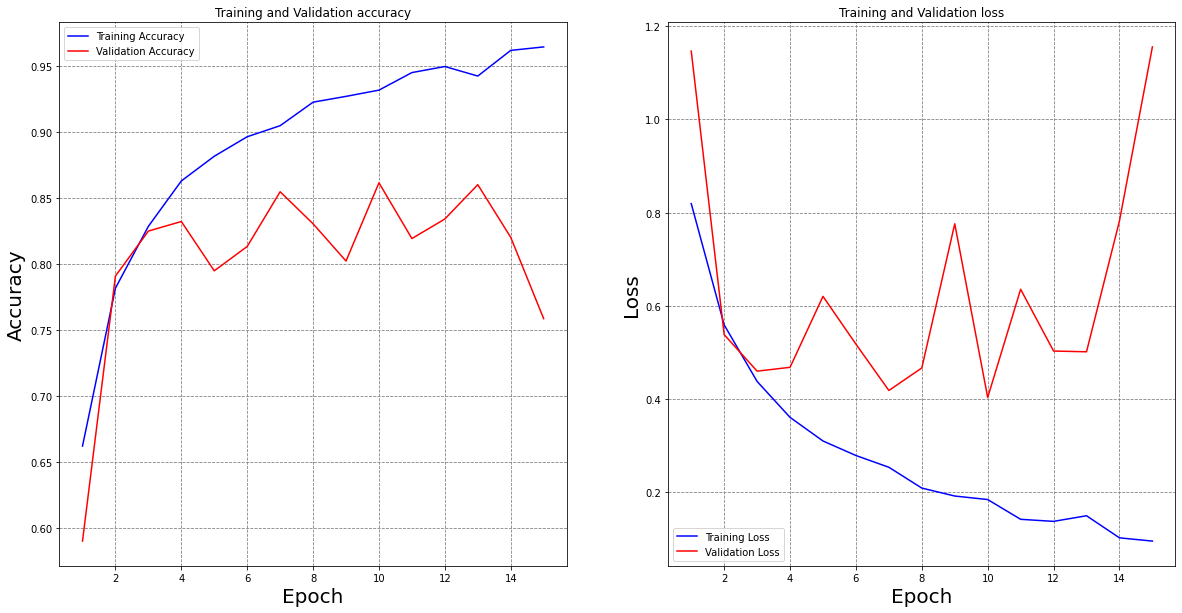

In [ ]:
plotLearningCurve(r,n_epochs)

In [ ]:
# printing model accuracy for train and test data
test_evaluation = model.evaluate(val_data)
print(f"Test Accuracy using ResNet50: {test_evaluation[1] * 100:.2f}%")

train_evaluation = model.evaluate(train_data)
print(f"Train Accuracy using ResNet50: {train_evaluation[1] * 100:.2f}%")

199/199 [==============================] - 17s 84ms/step - loss: 0.4034 - accuracy: 0.8617
Test Accuracy using ResNet50: 86.17%
464/464 [==============================] - 39s 83ms/step - loss: 0.1220 - accuracy: 0.9554
Train Accuracy using ResNet50: 95.54%


In [ ]:
y_pred  = np.round(model.predict(X_test))
y_pred_c = np.argmax(y_pred,axis = 1)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1081
           1       0.85      0.80      0.82      1801
           2       0.89      0.90      0.89      3052
           3       0.88      0.86      0.87       402

   micro avg       0.87      0.86      0.86      6336
   macro avg       0.86      0.85      0.85      6336
weighted avg       0.87      0.86      0.86      6336
 samples avg       0.86      0.86      0.86      6336



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


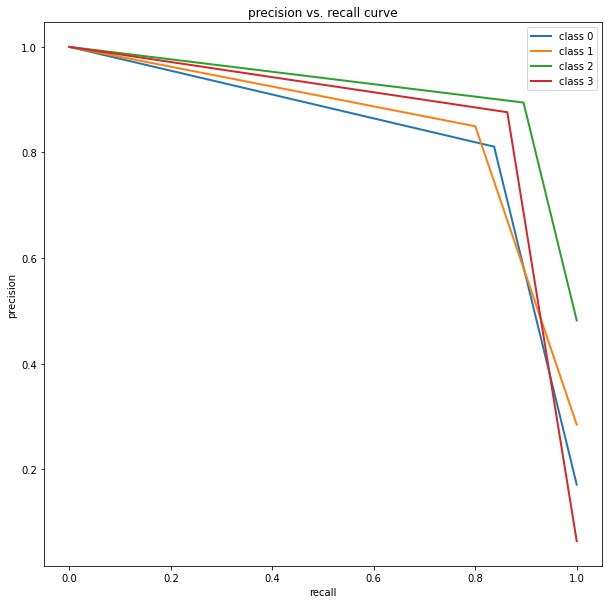

In [ ]:
plt.figure(figsize = (10,10))
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

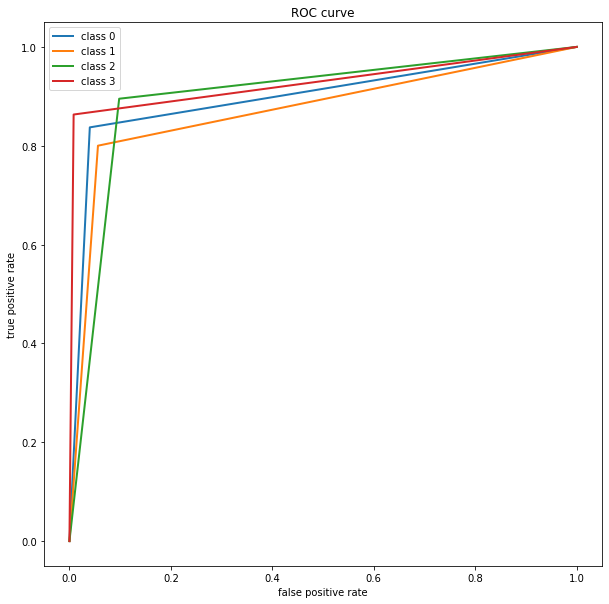

In [ ]:
plt.figure(figsize = (10,10))
fpr = dict()
tpr = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  y_pred[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

### 